# THOMAS FAIT MUMUSE ICI

In [53]:
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.io import loadmat
from scipy.io import whosmat
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import Viridis256
from bokeh.transform import transform
from scipy.sparse import csc_matrix, vstack
from sklearn.linear_model import LogisticRegression
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from sklearn.metrics import (
    accuracy_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# LOAD DES DATAFRAMES

In [5]:
df_test = pd.read_csv("../data/test.csv")

In [6]:
df_train = pd.read_csv("../data/train.csv")

In [7]:
print(df_train.head())

   _STATE  FMONTH    IDATE  IMONTH  IDAY  IYEAR  DISPCODE       SEQNO  \
0     2.0     5.0  5132022       5    13   2022    1100.0  2022000436   
1     9.0     1.0  2282022       2    28   2022    1200.0  2022005381   
2    19.0     1.0  1202022       1    20   2022    1100.0  2022000927   
3    39.0     8.0  8122022       8    12   2022    1100.0  2022014408   
4    25.0     7.0  7222022       7    22   2022    1200.0  2022010910   

           _PSU  CTELENM1  ...  DRNKANY6      DROCDY4_  _RFBING6  \
0  2.022000e+09       1.0  ...       1.0  2.700000e+01       1.0   
1  2.022005e+09       NaN  ...       9.0  9.000000e+02       9.0   
2  2.022001e+09       1.0  ...       2.0  5.397605e-79       1.0   
3  2.022014e+09       NaN  ...       2.0  5.397605e-79       1.0   
4  2.022011e+09       NaN  ...       1.0  1.700000e+01       2.0   

       _DRNKWK2  _RFDRHV8  _FLSHOT7  _PNEUMO3  _AIDTST4  ID  TARGET  
0  1.870000e+02       1.0       1.0       1.0       2.0   0    True  
1  9.990000e

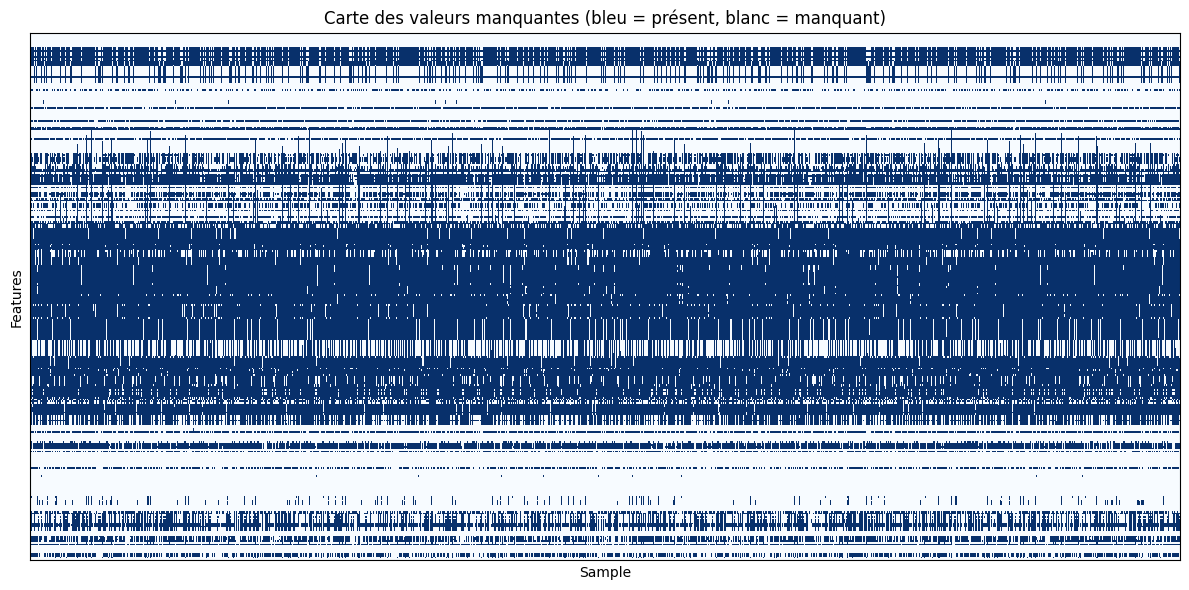

In [15]:
# Créer un masque booléen : 1 si manquant, 0 sinon
missing_mask = df_test.isna().astype(int)

plt.figure(figsize=(12, 6))

# Affichage avec imshow : chaque pixel représente une cellule
plt.imshow(missing_mask.T, aspect="auto", interpolation="none", cmap="Blues")

# Nettoyage des axes
plt.xticks([])  # lignes
plt.yticks([])  # colonnes

plt.xlabel("Sample")
plt.ylabel("Features")
plt.title("Carte des valeurs manquantes (bleu = présent, blanc = manquant)")

plt.tight_layout()
plt.show()

# Model de prediction nul

In [17]:
def train_model(algo, algo_params, 
                train_features, train_target) -> tuple[list, list]:
    """
    Trains our prediction model accros the different States
    """

    # print(f"Training model for state {states[s]}")
    model = algo(**algo_params)  # Unpack parameters
    model.fit(train_features, train_target)

    return model

In [21]:
ids = df_train["ID"]
train_target = df_train["TARGET"]
train_features = df_train.drop(columns=["TARGET", "ID"], errors='ignore')

model = train_model(
    HistGradientBoostingClassifier,
    {"max_iter": 100},  # itérations plus petites pour tester
    train_features,
    train_target
)

In [29]:
test_features = df_test.drop(columns=["ID"], errors='ignore')
predictions = model.predict(test_features)
nb_true = 0
for prediction in predictions :
    if prediction :
        nb_true += 1
print(f"on a predit {nb_true} arrêts cardiaques")

on a predit 1201 arrêts cardiaques


In [71]:
import sys
import os

sys.path.append(os.path.abspath("../soumission"))
from utils import soumission_csv as to_csv

def soumission_csv(model,df_data,indexes,filename="../data/prediction.csv"):
    """
    Génère un fichier csv de predictions reponse à soumettre à partir d'un model entrainé et d'un data_frame.
        
    Paramètres :
    - model, model entrainé 
    - df_data : data frame des données à predir, dois contenir la colone "ID" et les meme features que le model entrainé
    - filename : nom du fichier créé par la fonction
        
    Retour :
    - X_train_pca, X_test_pca : listes de matrices transformées
    - pca_list : liste des objets PCA par état
    - top_features_dict : dict avec top features par état
    """
    features = df_data.drop(columns=["ID"], errors='ignore')

    prediction = model.predict(features)

    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "TARGET"])  # En-têtes
        for index,id in enumerate(indexes) :
            writer.writerow([id, prediction[index]])
    print(f"Fichier '{filename}' créé avec succès !")
    return

In [72]:
soumission_csv(model,df_test,df_test["ID"],"../data/prediction_sans_nettoyage_données.csv")

Fichier '../data/prediction_sans_nettoyage_données.csv' créé avec succès !


# Model avec un peu de tri des colones

In [80]:
columns_of_interest = ['SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PRIMINSR', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'SLEPTIM1', 'LASTDEN4', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'WEIGHT2', 'HEIGHT3', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS', 'FLUSHOT7', 'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'FEETSORE', 'TOLDCFS', 'HAVECFS', 'WORKCFS', 'COVIDVA1', 'SHINGLE2', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVDOC1', 'CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEPUNCH', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHSTRE1', 'MARIJAN1', 'MARJSMOK']

columns_present = [col for col in columns_of_interest if col in df_train.columns]
train_target_of_interest = df_train[columns_present]

model_of_interest = train_model(HistGradientBoostingClassifier,
                                {"max_iter": 100},  # itérations plus petites pour tester
                                train_target_of_interest,
                                train_target)

In [86]:
test_target_of_interest = df_test[columns_present]

prediction_of_interest = model_of_interest.predict(train_target_of_interest)

nb_true = 0
for prediction in prediction_of_interest :
    if prediction :
        nb_true += 1
print(f"on a predit {nb_true} arrêts cardiaques")

nb_true = 0
for prediction in train_target :
    if prediction :
        nb_true += 1
print(f"En vrai il y avait {nb_true} arrêts cardiaques")


soumission_csv(model_of_interest,test_target_of_interest,df_test["ID"],"../data/prediction_colon_of_interest.csv")

on a predit 2981 arrêts cardiaques
En vrai il y avait 20139 arrêts cardiaques
Fichier '../data/prediction_colon_of_interest.csv' créé avec succès !


In [84]:
# Prédictions
yhat_rf = model_of_interest.predict(train_target_of_interest)

# Convertir bool → int
yhat_rf_int = yhat_rf.astype(int)
train_target_int = train_target.astype(int)

# Calcul de l'erreur quadratique moyenne (MSE)
error2_rf = np.sum((yhat_rf_int - train_target_int) ** 2) / len(train_target_int)

print(f"Classification error on training set : {round(error2_rf*100, 1)} %")

Classification error on training set : 8.6 %
